In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-analysis-dataset/Data Dictionary.xls
/kaggle/input/credit-risk-analysis-dataset/cs-training.csv
/kaggle/input/credit-risk-analysis-dataset/sampleEntry.csv
/kaggle/input/credit-risk-analysis-dataset/cs-test.csv


# **Step 1: Setup and Data Loading**
# **==============================**

In [3]:
!pip install -U scikit-learn==1.2.2
!pip install -U imbalanced-learn==0.10.1
!pip install -U xgboost==1.7.6
!pip install -U pandas matplotlib seaborn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.1 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 8.3 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 59.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully unin

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set the random seed for reproducibility
np.random.seed(42)

# Step 1.1: Download and load the dataset
# ------------------------------------

In [6]:
# Create a checkpoint directory for saving progress
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

In [7]:
df = pd.read_csv('/kaggle/input/credit-risk-analysis-dataset/cs-training.csv')
# Save to checkpoint
df.to_csv('checkpoints/credit_data.csv', index=False)
print("Dataset downloaded and saved to checkpoint.")

Dataset downloaded and saved to checkpoint.


In [8]:
# Display basic dataset information
print("\nDataset Overview:")
print(f"Shape: {df.shape}")
print("\nColumn Names:")
print(df.columns)
print("\nSample Data:")
print(df.head())


Dataset Overview:
Shape: (150000, 12)

Column Names:
Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

Sample Data:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                     

# Step 2: Data Exploration and Understanding
# =========================================

### 2.1: Basic data statistics

In [9]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
          Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866       

### 2.2: Check missing values

In [10]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_info)

                                      Missing Values  Percentage
Unnamed: 0                                         0    0.000000
SeriousDlqin2yrs                                   0    0.000000
RevolvingUtilizationOfUnsecuredLines               0    0.000000
age                                                0    0.000000
NumberOfTime30-59DaysPastDueNotWorse               0    0.000000
DebtRatio                                          0    0.000000
MonthlyIncome                                  29731   19.820667
NumberOfOpenCreditLinesAndLoans                    0    0.000000
NumberOfTimes90DaysLate                            0    0.000000
NumberRealEstateLoansOrLines                       0    0.000000
NumberOfTime60-89DaysPastDueNotWorse               0    0.000000
NumberOfDependents                              3924    2.616000


### 2.3: Target variable distribution (check class imbalance)

In [11]:
# Assuming 'SeriousDlqin2yrs' is the target variable (1=defaulted, 0=non-defaulted)
target_col = 'SeriousDlqin2yrs'
target_counts = df[target_col].value_counts()
target_percentage = target_counts / len(df) * 100

print(f"Target distribution:\n{target_counts}")
print(f"Target percentage:\n{target_percentage}")

# Save exploration results as checkpoint
joblib.dump(missing_info, 'checkpoints/missing_info.pkl')
joblib.dump([target_counts, target_percentage], 'checkpoints/target_info.pkl')

Target distribution:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64
Target percentage:
SeriousDlqin2yrs
0    93.316
1     6.684
Name: count, dtype: float64


['checkpoints/target_info.pkl']

### 2.4: Visualize the data

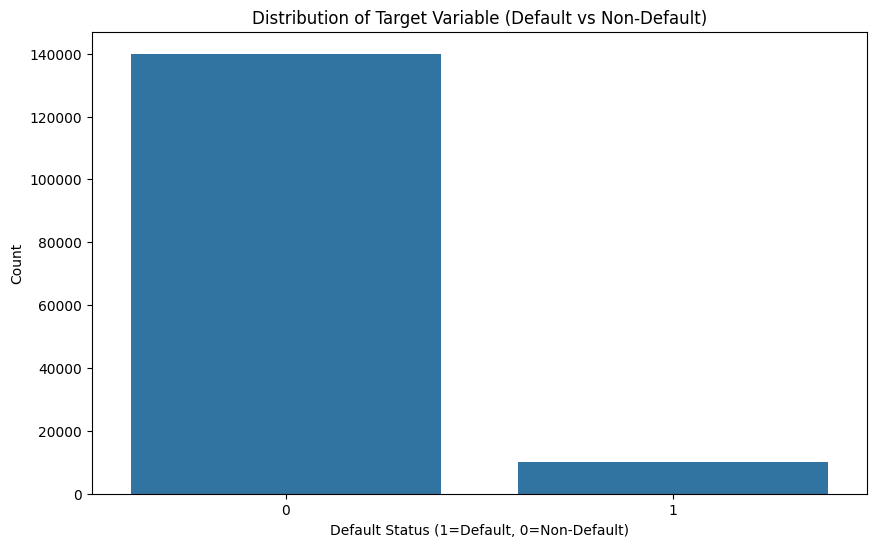

In [12]:
# Fix column names if needed
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=target_col, data=df)
plt.title('Distribution of Target Variable (Default vs Non-Default)')
plt.xlabel('Default Status (1=Default, 0=Non-Default)')
plt.ylabel('Count')
plt.show()

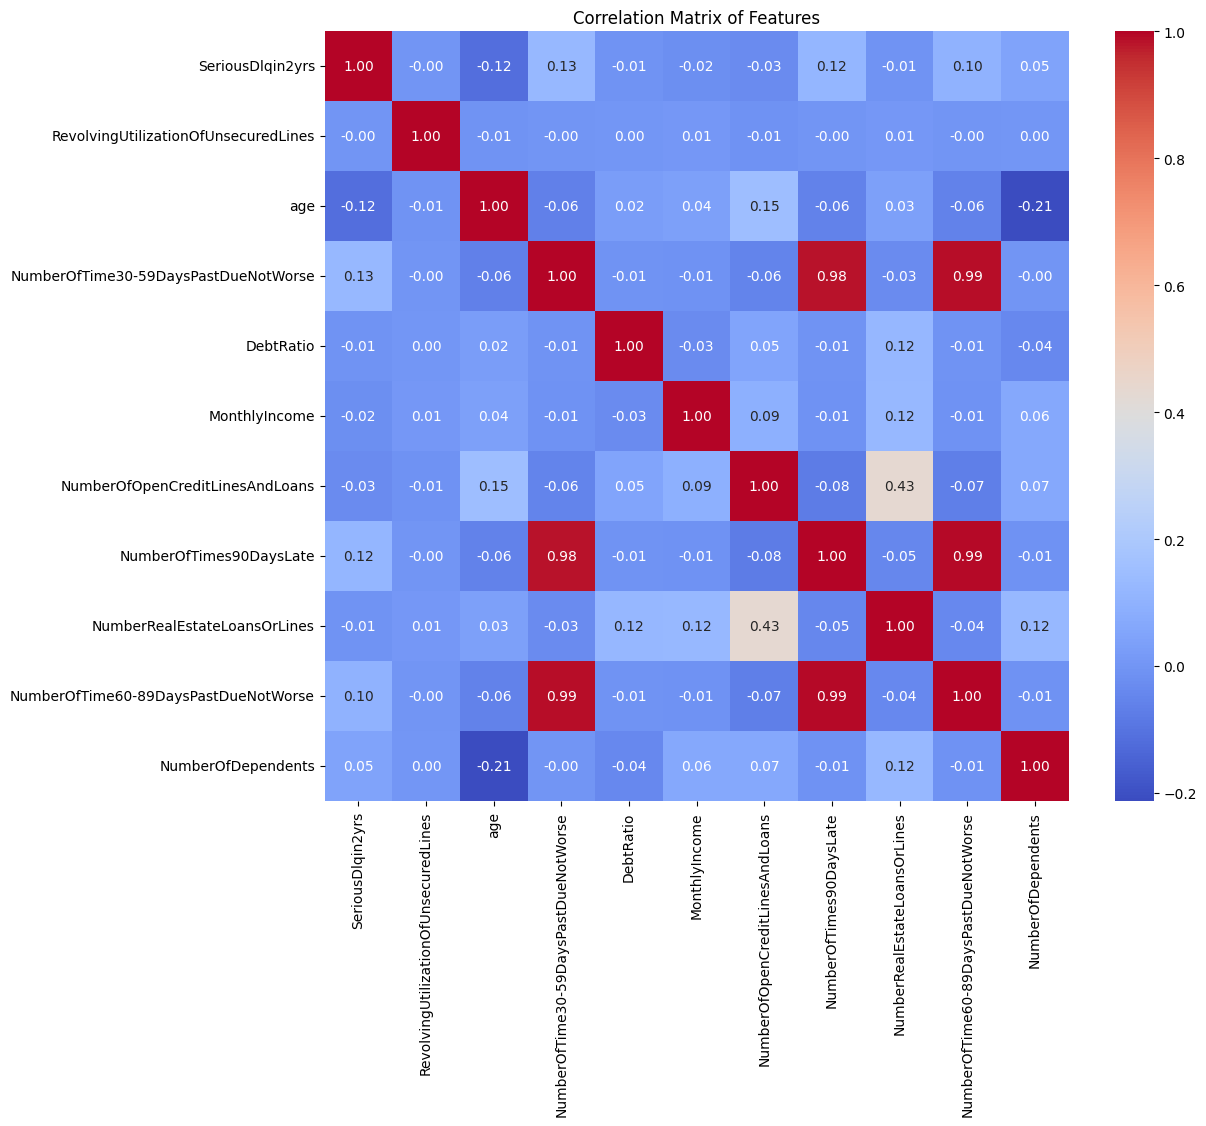

In [13]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

# **Step 3: Data Preprocessing**
# **=========================**

### **3.1: Handle missing values**

In [14]:
# Save original data for comparison
original_df = df.copy()

# Strategy for numerical features: impute with median (more robust to outliers than mean)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Verify missing values have been addressed
print(f"Missing values after imputation: {df.isnull().sum().sum()}")

# Save the imputer for use in production
joblib.dump(imputer, 'checkpoints/imputer.pkl')

Missing values after imputation: 0


['checkpoints/imputer.pkl']

### **3.2: Handle outliers**

In [15]:
# Function to detect and cap outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    df[column] = np.where(
        df[column] > upper_bound,
        upper_bound,
        np.where(
            df[column] < lower_bound,
            lower_bound,
            df[column]
        )
    )
    return df

# Apply outlier handling to numeric columns (except target)
numeric_features = [col for col in numeric_cols if col != target_col]
for column in numeric_features:
    df = handle_outliers(df, column)

print("Outliers have been handled using IQR method")

Outliers have been handled using IQR method


### **3.3: Feature engineering**

In [16]:
# Creating new features related to income, debt, and repayment history
# 1. Debt-to-Income ratio
df['DebtToIncome'] = df['DebtRatio']

# 2. Ratio of credit line usage
df['CreditLineUsageRatio'] = df['RevolvingUtilizationOfUnsecuredLines']

# 3. Monthly debt burden relative to income
if 'MonthlyIncome' in df.columns:
    df['MonthlyDebtBurden'] = df['DebtRatio'] * df['MonthlyIncome']

# 4. Debt per dependent
if 'NumberOfDependents' in df.columns:
    # Handle division by zero
    df['DebtPerDependent'] = df['DebtRatio'] / (df['NumberOfDependents'].replace(0, 1))

# 5. Credit to debt ratio
df['CreditToDebtRatio'] = df['NumberOfOpenCreditLinesAndLoans'] / (df['DebtRatio'] + 1)  # +1 to avoid division by zero

# 6. Past due severity score
past_due_cols = [col for col in df.columns if 'NumberOfTimes' in col and 'PastDue' in col]
if past_due_cols:
    df['PastDueSeverityScore'] = df[past_due_cols].sum(axis=1)

print(f"Created new features: {list(set(df.columns) - set(original_df.columns))}")

Created new features: ['DebtToIncome', 'MonthlyDebtBurden', 'CreditLineUsageRatio', 'DebtPerDependent', 'CreditToDebtRatio']


### **3.4: Feature scaling**

In [17]:
# Define features and target
X = df.drop(target_col, axis=1)
y = df[target_col]

# Standard scaling for features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Features have been scaled using StandardScaler")

# Save the scaler for production
joblib.dump(scaler, 'checkpoints/scaler.pkl')

Features have been scaled using StandardScaler


['checkpoints/scaler.pkl']

### **3.5: Handle class imbalance with SMOTE**

In [18]:
# Split data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_smote.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Resampled class distribution: {pd.Series(y_train_smote).value_counts(normalize=True)}")

# Save resampled data
joblib.dump([X_train_smote, y_train_smote], 'checkpoints/resampled_train_data.pkl')
joblib.dump([X_test, y_test], 'checkpoints/test_data.pkl')

Original training set shape: (120000, 15)
Resampled training set shape: (223958, 15)
Original class distribution: SeriousDlqin2yrs
0.0    0.933158
1.0    0.066842
Name: proportion, dtype: float64
Resampled class distribution: SeriousDlqin2yrs
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


['checkpoints/test_data.pkl']

# **Step 4: Model Development**
# **=======================**

In [19]:
# Function to evaluate and plot model performance
def evaluate_model(model, X_test, y_test, model_name):
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    print(f"\nModel: {model_name}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.show()
    
    # Return metrics for comparison
    metrics = {
        'model_name': model_name,
        'accuracy': (y_pred == y_test).mean(),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }
    
    return metrics

### 4.1: Train Random Forest model


Model: Random_Forest

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87     27995
         1.0       0.18      0.68      0.29      2005

    accuracy                           0.77     30000
   macro avg       0.58      0.73      0.58     30000
weighted avg       0.92      0.77      0.83     30000



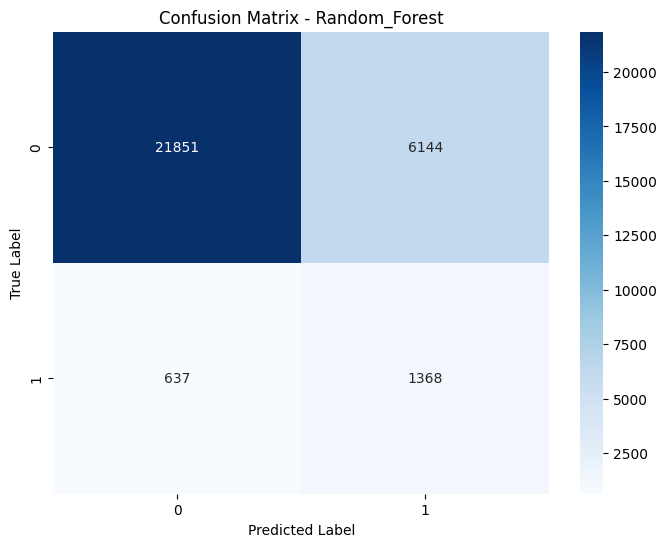

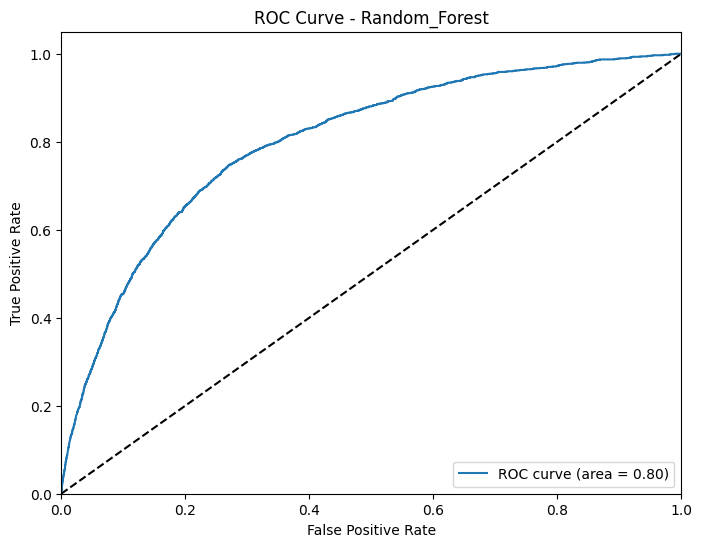

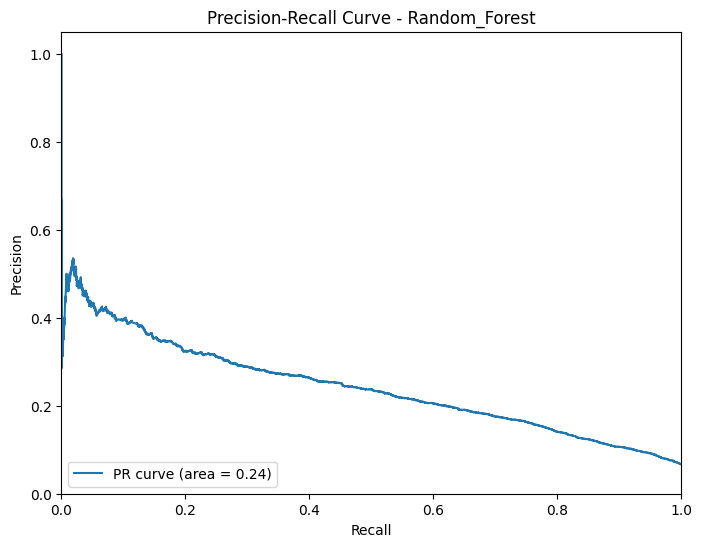

['checkpoints/random_forest_model.pkl']

In [20]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_smote, y_train_smote)
rf_metrics = evaluate_model(rf_model, X_test, y_test, 'Random_Forest')

# Save the model
joblib.dump(rf_model, 'checkpoints/random_forest_model.pkl')

### 4.2: Train Gradient Boosting model


Model: Gradient_Boosting

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91     27995
         1.0       0.23      0.53      0.32      2005

    accuracy                           0.85     30000
   macro avg       0.59      0.70      0.61     30000
weighted avg       0.91      0.85      0.87     30000



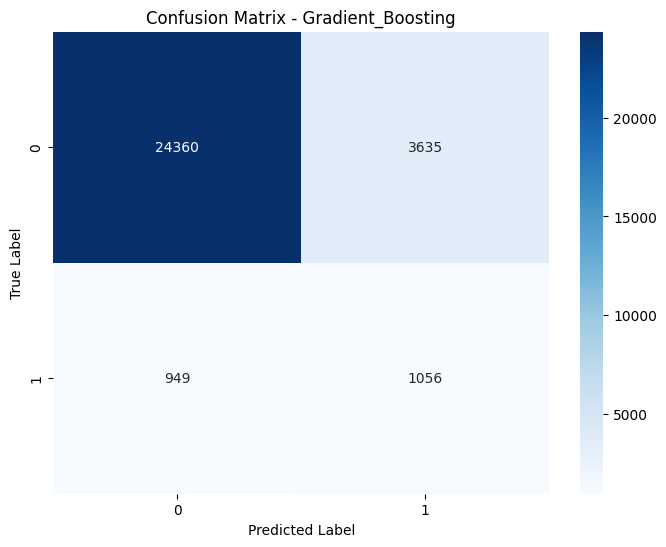

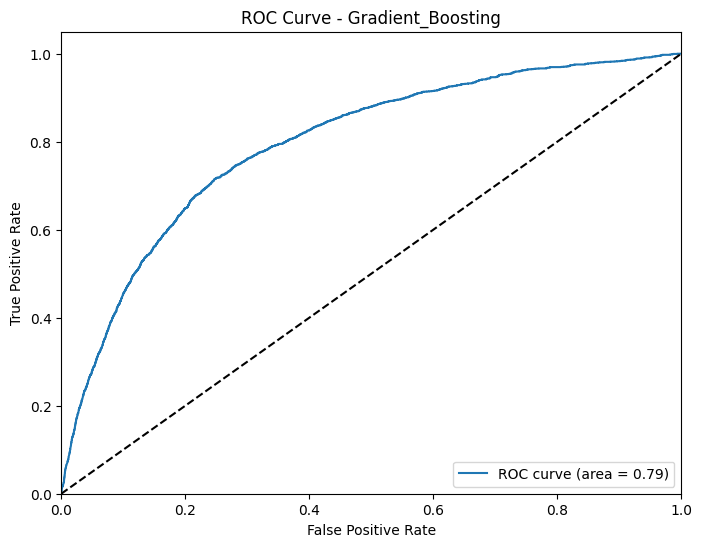

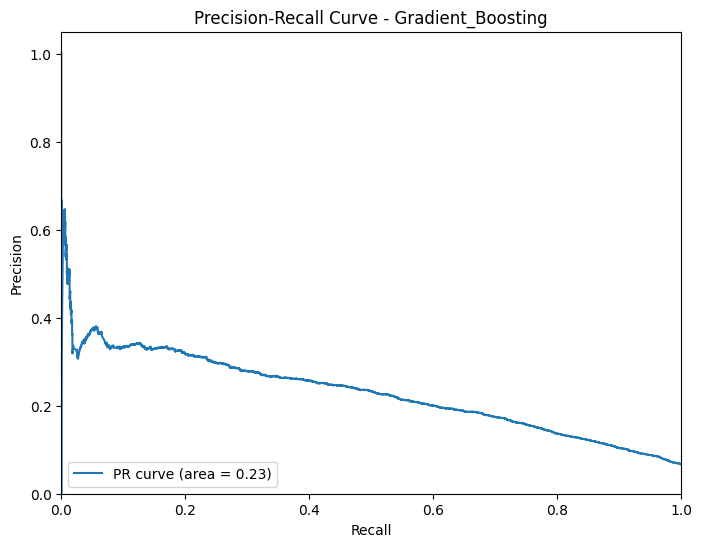

['checkpoints/gradient_boosting_model.pkl']

In [21]:
# Create and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

gb_model.fit(X_train_smote, y_train_smote)
gb_metrics = evaluate_model(gb_model, X_test, y_test, 'Gradient_Boosting')

# Save the model
joblib.dump(gb_model, 'checkpoints/gradient_boosting_model.pkl')

### 4.3: Train XGBoost model


Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91     27995
         1.0       0.23      0.53      0.32      2005

    accuracy                           0.85     30000
   macro avg       0.59      0.70      0.62     30000
weighted avg       0.91      0.85      0.87     30000



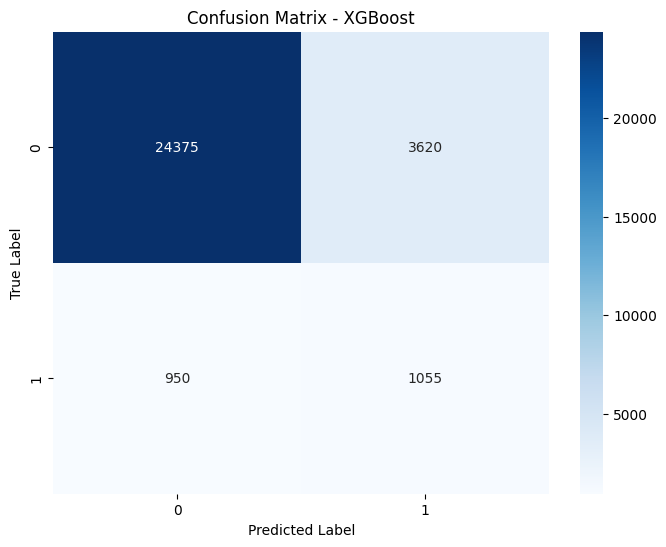

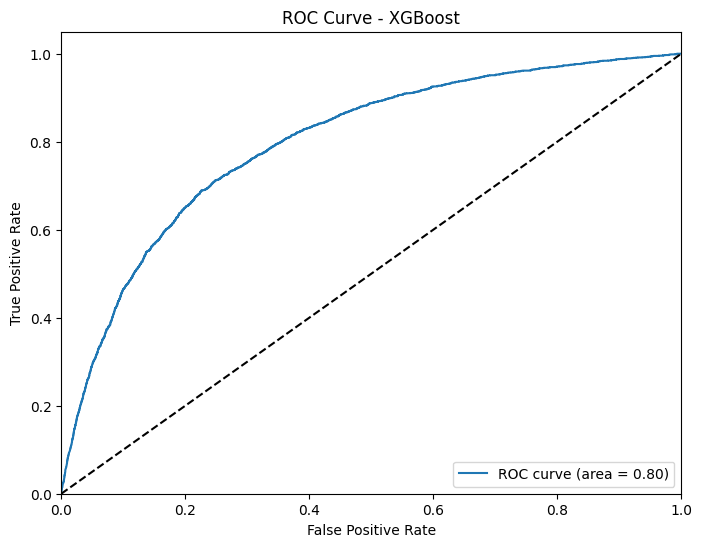

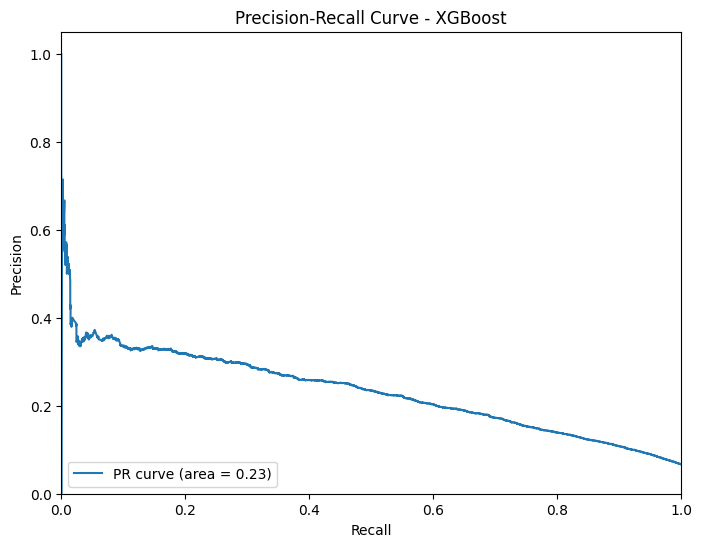

['checkpoints/xgboost_model.pkl']

In [22]:
# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_smote, y_train_smote)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

# Save the model
joblib.dump(xgb_model, 'checkpoints/xgboost_model.pkl')

### 4.4: Model comparison

In [23]:
# Compare model performance
models_metrics = [rf_metrics, gb_metrics, xgb_metrics]
metrics_df = pd.DataFrame(models_metrics)
print("\nModel Performance Comparison:")
print(metrics_df)

# Identify the best model based on ROC AUC
best_model_idx = metrics_df['roc_auc'].idxmax()
best_model_name = metrics_df.loc[best_model_idx, 'model_name']
print(f"\nBest performing model based on ROC AUC: {best_model_name}")

# Select the best model based on comparison
if best_model_name == 'Random_Forest':
    best_model = rf_model
elif best_model_name == 'Gradient_Boosting':
    best_model = gb_model
else:  # XGBoost
    best_model = xgb_model

# Save best model separately
joblib.dump(best_model, 'checkpoints/best_model.pkl')


Model Performance Comparison:
          model_name  accuracy   roc_auc    pr_auc
0      Random_Forest  0.773967  0.800216  0.241580
1  Gradient_Boosting  0.847200  0.794463  0.228393
2            XGBoost  0.847667  0.797508  0.231450

Best performing model based on ROC AUC: Random_Forest


['checkpoints/best_model.pkl']

# **Step 5: Feature Importance Analysis**
# **=================================**

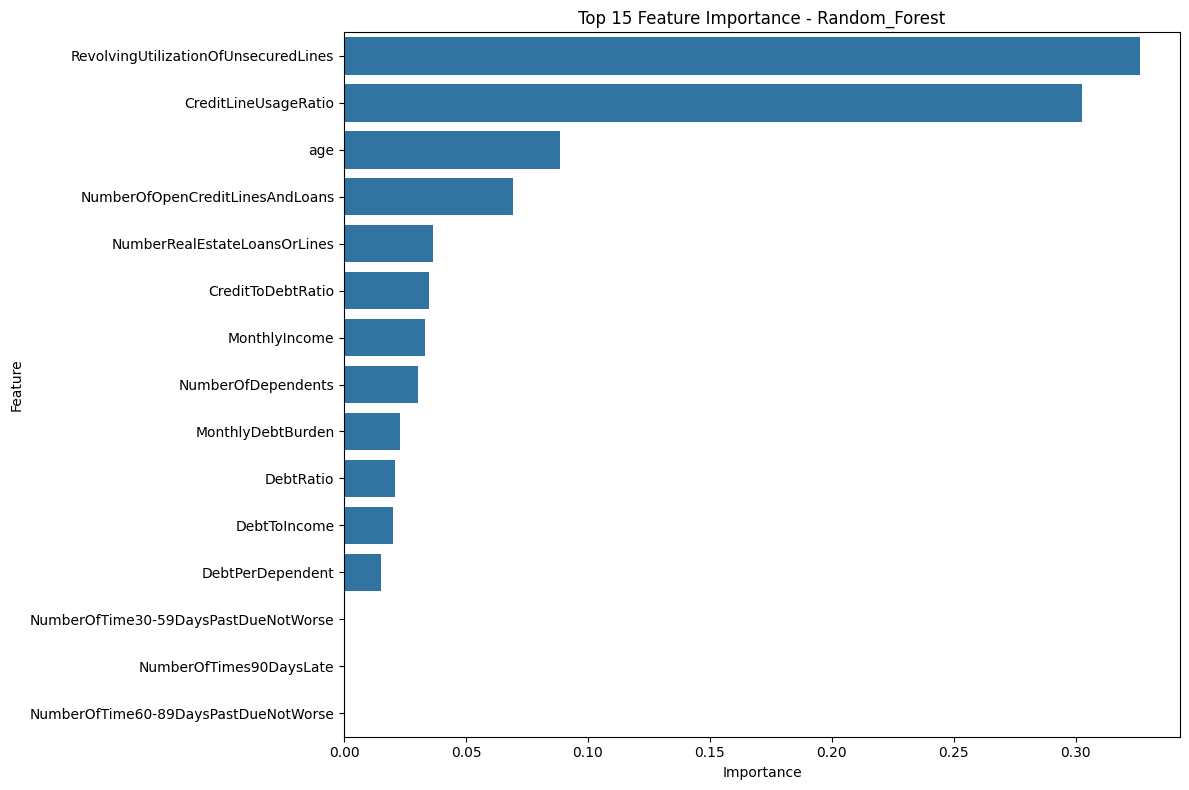


Top 10 important features:
                                 Feature  Importance
0   RevolvingUtilizationOfUnsecuredLines    0.326477
11                  CreditLineUsageRatio    0.302760
1                                    age    0.088466
5        NumberOfOpenCreditLinesAndLoans    0.069076
7           NumberRealEstateLoansOrLines    0.036455
14                     CreditToDebtRatio    0.034658
4                          MonthlyIncome    0.033186
9                     NumberOfDependents    0.030213
12                     MonthlyDebtBurden    0.022715
3                              DebtRatio    0.020858


In [24]:
# Get feature importance from the best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 important features:")
    print(importance_df.head(10))
else:
    print("Feature importance not available for the selected model")

# **Step 6: Model Deployment Preparation**
# **==================================**

### 6.1: Create a credit risk assessment pipeline

In [34]:

# Create a reusable pipeline
credit_risk_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Explicitly fit the pipeline on the training data before saving
credit_risk_pipeline.fit(X_train, y_train)

# Save the entire fitted pipeline
joblib.dump(credit_risk_pipeline, 'checkpoints/credit_risk_pipeline.pkl')

['checkpoints/credit_risk_pipeline.pkl']

### 6.2: Define risk thresholds

In [26]:
# Calculate optimal threshold based on ROC curve
def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # Find the optimal point (closest to top-left corner)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)

print(f"Default threshold (0.5) accuracy: {(best_model.predict(X_test) == y_test).mean():.4f}")

# Apply optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_accuracy = (y_pred_optimal == y_test).mean()

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Optimal threshold accuracy: {optimal_accuracy:.4f}")

# Save threshold information
threshold_info = {
    'default_threshold': 0.5,
    'optimal_threshold': optimal_threshold
}
joblib.dump(threshold_info, 'checkpoints/threshold_info.pkl')

Default threshold (0.5) accuracy: 0.7740
Optimal threshold: 0.4236
Optimal threshold accuracy: 0.7308


['checkpoints/threshold_info.pkl']

### 6.3: Design a risk scoring system

In [27]:
# Create a function to convert probabilities into risk categories
def risk_score_calculator(probability, threshold_low=0.3, threshold_high=0.7):
    if probability < threshold_low:
        return "Low Risk"
    elif probability < threshold_high:
        return "Medium Risk"
    else:
        return "High Risk"

# Define risk thresholds
risk_thresholds = {
    'low': 0.3,
    'high': 0.7
}

# Apply to test data as example
risk_scores = np.array([risk_score_calculator(p, risk_thresholds['low'], risk_thresholds['high']) 
                         for p in y_pred_proba])

# Show distribution of risk categories
risk_distribution = pd.Series(risk_scores).value_counts()
print("\nRisk score distribution in test data:")
print(risk_distribution)

# Save risk scoring function and thresholds
joblib.dump(risk_thresholds, 'checkpoints/risk_thresholds.pkl')


Risk score distribution in test data:
Low Risk       15986
Medium Risk    10297
High Risk       3717
Name: count, dtype: int64


['checkpoints/risk_thresholds.pkl']

# **Step 7: Final Model and System Evaluation**
# **=======================================**

### 7.1: Evaluate business impact

In [28]:
# Calculate potential business metrics
# 1. Default rate reduction estimation
current_default_rate = y_test.mean()  # Proportion of defaults in test data

# Let's say we decline service to "High Risk" customers
high_risk_mask = risk_scores == "High Risk"
high_risk_default_rate = y_test[high_risk_mask].mean()
remaining_customers = len(y_test) - sum(high_risk_mask)
remaining_default_rate = y_test[~high_risk_mask].mean()

default_reduction = (current_default_rate - remaining_default_rate) * 100

print(f"Current default rate: {current_default_rate:.2%}")
print(f"Default rate among high-risk customers: {high_risk_default_rate:.2%}")
print(f"Estimated default rate after filtering high-risk customers: {remaining_default_rate:.2%}")
print(f"Potential reduction in default rate: {default_reduction:.2%} percentage points")

Current default rate: 6.68%
Default rate among high-risk customers: 24.54%
Estimated default rate after filtering high-risk customers: 4.16%
Potential reduction in default rate: 252.48% percentage points


In [29]:
# 2. Cost-benefit analysis (simplified)
avg_loan_amount = 10000  # Assume average loan of $10,000
cost_of_default = 0.7  # Assume 70% of loan amount is lost on default
acquisition_cost = 100  # Cost to acquire a customer
decline_cost = 10  # Cost of declining a customer (administrative)

# Without model
expected_loss_without_model = len(y_test) * current_default_rate * avg_loan_amount * cost_of_default
print(f"\nEstimated loss without model: ${expected_loss_without_model:.2f}")

# With model
customers_declined = sum(high_risk_mask)
defaults_prevented = customers_declined * high_risk_default_rate
defaults_remaining = (len(y_test) - customers_declined) * remaining_default_rate

expected_loss_with_model = defaults_remaining * avg_loan_amount * cost_of_default
decline_costs = customers_declined * decline_cost

print(f"Estimated loss with model: ${expected_loss_with_model:.2f}")
print(f"Cost of declining customers: ${decline_costs:.2f}")
print(f"Number of customers declined: {customers_declined}")
print(f"Estimated defaults prevented: {defaults_prevented:.2f}")


Estimated loss without model: $14035000.00
Estimated loss with model: $7651000.00
Cost of declining customers: $37170.00
Number of customers declined: 3717
Estimated defaults prevented: 912.00


In [30]:
# Total benefit
total_benefit = expected_loss_without_model - expected_loss_with_model - decline_costs
print(f"\nEstimated total benefit of model: ${total_benefit:.2f}")

# Save business impact analysis
business_impact = {
    'current_default_rate': current_default_rate,
    'high_risk_default_rate': high_risk_default_rate,
    'remaining_default_rate': remaining_default_rate,
    'default_reduction': default_reduction,
    'total_benefit': total_benefit
}
joblib.dump(business_impact, 'checkpoints/business_impact.pkl')


Estimated total benefit of model: $6346830.00


['checkpoints/business_impact.pkl']

### 7.2: Final model validation

In [31]:
# Validate model with cross-validation
cv_scores = cross_val_score(best_model, X_scaled_df, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Cross-validation ROC AUC scores: [0.80582069 0.79964097 0.80274874 0.80889415 0.80815278]
Mean CV ROC AUC: 0.8051 (±0.0035)


# **Step 8: Production System Design**
# **==============================**

### 8.1: Create a sample prediction function

In [32]:
def predict_credit_risk(customer_data, pipeline=None, risk_thresholds=None):
    """
    Predicts credit risk for a customer using the trained model.
    
    Args:
        customer_data (dict or DataFrame): Customer information
        pipeline (Pipeline): Trained model pipeline
        risk_thresholds (dict): Risk category thresholds
        
    Returns:
        dict: Prediction results including risk score and category
    """
    # Load model if not provided
    if pipeline is None:
        pipeline = joblib.load('checkpoints/credit_risk_pipeline.pkl')
    
    # Load thresholds if not provided
    if risk_thresholds is None:
        risk_thresholds = joblib.load('checkpoints/risk_thresholds.pkl')
    
    # Convert dictionary to DataFrame if needed
    if isinstance(customer_data, dict):
        customer_data = pd.DataFrame([customer_data])
    
    # Make prediction
    risk_probability = pipeline.predict_proba(customer_data)[:, 1]
    
    # Assign risk category
    risk_categories = []
    for prob in risk_probability:
        if prob < risk_thresholds['low']:
            risk_categories.append("Low Risk")
        elif prob < risk_thresholds['high']:
            risk_categories.append("Medium Risk")
        else:
            risk_categories.append("High Risk")
    
    # Prepare results
    results = {
        'risk_probability': risk_probability.tolist(),
        'risk_category': risk_categories,
        'recommendation': ["Approve" if cat != "High Risk" else "Decline" for cat in risk_categories]
    }
    
    return results

In [35]:
# Test the prediction function
sample_customer = X_test.iloc[0].to_dict()
prediction = predict_credit_risk(sample_customer)
print("\nSample prediction:")
print(f"Risk probability: {prediction['risk_probability'][0]:.4f}")
print(f"Risk category: {prediction['risk_category'][0]}")
print(f"Recommendation: {prediction['recommendation'][0]}")


Sample prediction:
Risk probability: 0.0237
Risk category: Low Risk
Recommendation: Approve


### 8.2: Save the final production-ready system

In [37]:
# Package all necessary components
production_package = {
    'pipeline': joblib.load('checkpoints/credit_risk_pipeline.pkl'),
    'risk_thresholds': risk_thresholds,
    'feature_importance': importance_df.to_dict() if 'importance_df' in locals() else None,
    'model_metrics': {
        'roc_auc': metrics_df['roc_auc'].max(),
        'optimal_threshold': optimal_threshold
    }
}

# Save the complete production package
joblib.dump(production_package, 'credit_risk_production_system.pkl')

print("\nCredit risk analysis system has been successfully developed and saved!")
print("The final production system is available as 'credit_risk_production_system.pkl'")


Credit risk analysis system has been successfully developed and saved!
The final production system is available as 'credit_risk_production_system.pkl'


# **Step 9: Summary**
# **===========================**

# *Credit Risk Analysis Project Summary:*
**-------------------------------------**
### 1. We loaded and explored the 'Give Me Some Credit' dataset.
### 2. We preprocessed the data by handling missing values and outliers.
### 3. We engineered new features related to income, debt, and repayment history.
### 4. We handled class imbalance using SMOTE.
### 5. We trained and evaluated three models: Random Forest, Gradient Boosting, and          XGBoost.
### 6. We analyzed feature importance to understand key risk factors.
### 7. We created a risk scoring system to categorize customers.
### 8. We evaluated the business impact of the model.
### 9. We packaged the system for production use.